# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record
  - offer id: (string/hash) not associated with any "transaction"
  - amount: (numeric) money spent in "transaction"
  - reward: (numeric) money gained from "offer completed"



In [9]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.metrics import roc_auc_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Access, Clean and Analyze Data

### Customer Demographic Data

Business question to think when we analyze the data:

- What is the gender distribution among our customers? Do women or men consume more our product?
- What is the income level of the customers? Low, medium or high class?
- What is the most consuming age group among our customers?
- Is there any correlation between gender, age and income?

I will analyze the data and also visualize them to help people better understand our customer profile.

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
profile.id.count()

17000

In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


The maximum age is 118 year old, this information does not look reliable. Let´s look at it better with a visualization.

### Age Distribution

In [12]:
profile['age'].isnull().sum()

0

There is no missing data in this column. Good!

Text(0.5, 1.0, 'Age distribution')

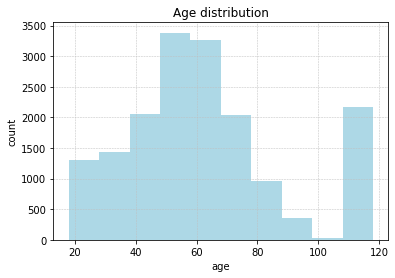

In [13]:
plt.hist(profile['age'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('age')
plt.ylabel('count')
plt.title('Age distribution')

In [14]:
profile[(profile['age']>= 100)].count()

gender                17
age                 2192
id                  2192
became_member_on    2192
income                17
dtype: int64

There are 2192 users with age equal or more than 100 years old, we might not need to include this age range in our analysis since it is probably a error o default setting. **We can conclude that the users of Starbuck are concentrated in the age from 39 to 79 years old.**

### Gender Distribution

In [15]:
profile['gender'].isnull().sum()

2175

In [16]:
profile[(profile['gender'].isnull())]['age'].value_counts()

118    2175
Name: age, dtype: int64

There are 2175 people have not defined their gender. Which is 12.8% of the total users. As you can see the people who have not defined the age are the people who have 118 years old which is probably an error. **We will like to drop these users with 118 years old and without gender.**

In [17]:
profile = profile[pd.notnull(profile['gender'])]

Text(0.5, 1.0, 'Gender distribution')

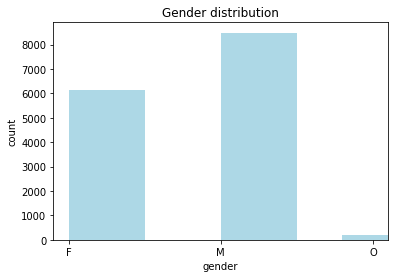

In [18]:
plt.hist(profile['gender'], color = 'lightblue', width=0.5)
plt.xlabel('gender')
plt.ylabel('count')
plt.title('Gender distribution')

In [20]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Is not hard to see that there are much more female users than male users, in total there are 57% are male, 41% are female, and 2% is not defined the gender.

### Income Distribution

Text(0.5, 1.0, 'Income distribution')

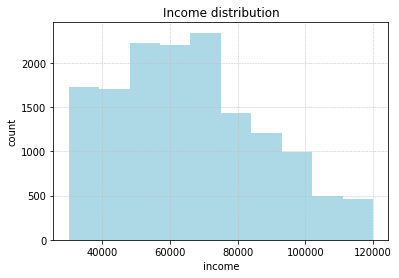

In [19]:
plt.hist(profile['income'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('income')
plt.ylabel('count')
plt.title('Income distribution')

The range of the users income is from 30k to 120k dollar annually, the highest intensity income is from 50k to 75k. We can see that the **users of starbucks are widely spread across almost all the social class of people, but mainly in the middle class.**

### Correlations of Demographic Data

Text(0.5, 1, 'Correlation of Gener,Age and Income')

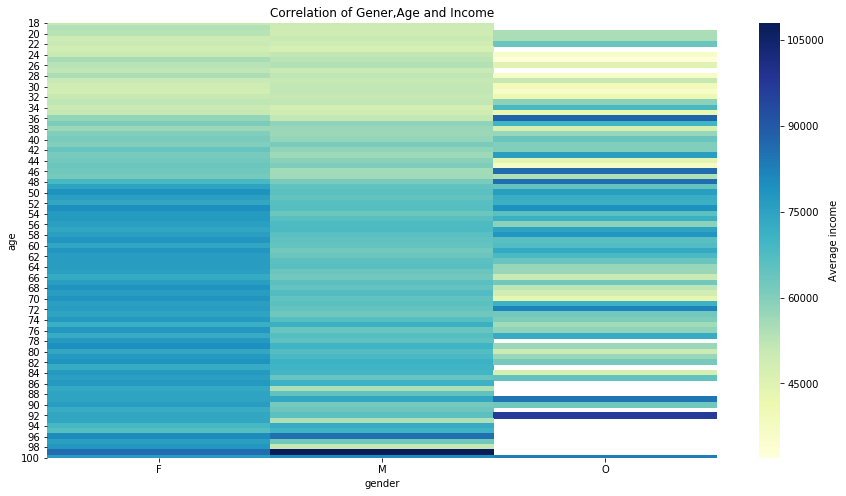

In [21]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(pd.crosstab(profile['age'],profile['gender'], values =profile['income'], aggfunc='mean'), 
                 cmap='YlGnBu',cbar_kws={'label': 'Average income'})
ax.set_title('Correlation of Gener,Age and Income')

<Figure size 1080x576 with 0 Axes>

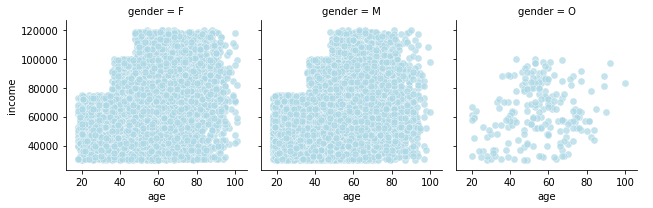

In [22]:
plt.figure(figsize=(15,8))
kws = dict(s=50, linewidth=.5, edgecolor="w")
ax = sns.FacetGrid(data = profile, col = 'gender');
ax.map(plt.scatter, 'age', 'income', alpha=0.7, color = 'lightblue',**kws);
ax.add_legend();

Is not hard to see from this graph that **the female users have higher average income than male**. The correlation between female income and age is positive, which means older they become the higher income they gain. From 48 years old, the female users start to have middel high income. But the average income of male users are very variable. They can have a very advanced age but without earning a good salary. 

### Customer Transcript Data

Business question to think when we analyze the data:

- How can we define the customer by their purchasing behavior?
- How many users are affected by the promotions?
- How many users are not affected by the promotions? Or how many of them ignore the promotions?
- How many users will buy starbuck products anyway even without receive promotion?
- How can we relate the customer purchasing behavior with their demographic information?
- Which age group wil be most influyed by promotion? Which age group is least influyed?
- Which income group will be most influyed by promotion? Which income group is least influyed?
- Which age/income/gender group are our loyal customer will buy product even without promotion?

Let´s firstly define our users in different groups based on their purchasing behaviors.

**Group 1: customers effected by promotion**

- Behaviors 1: Offer received - offer viewed - transaction - offer completed
- Behaviors 2: Offer received - offer viewed -  transaction (In case of informational offer will not have offer completed)

**Group 2: customers no effected by promotions**

- Behaviors 1: Offer received 
- Behaviors 2: Offer received - offer viewed

**Group 3: loyal customers (buy Starbucks anyway)**

- Behaviors 1: transaction - offer received
- Behaviors 2: transaction - offer received - offer viewed
- Behaviors 3: offer received - transaction
- Behaviors 4: offer received - transaction - offer viewed

Now we have defined 3 groups of users, Group 1 is most interesting for us to know who or how many customers are effectively influyed by the promotion. Group 3 is already our customers, we can save our cost to not spend more on them. Group 2 is the most tricky group, once we found out them, we can think about different strategies or promotions on them.



In [23]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [24]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [25]:
transcript['value'].iloc[306527]

{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}

In [26]:
# Lets add one empty column
transcript['offer_id'] = None
# Create one table with only offer receive and offer viewed and another table with offer completed. Because offer completed
# rows have different format then another offers, and there are also reward involved the offer completed
transcript_offer1 = transcript[transcript.event.isin(['offer received', 'offer viewed'])]
transcript_offer2 = transcript[transcript.event == 'offer completed']
transcript_transaction = transcript[transcript.event == 'transaction']

In [27]:
transcript_offer1.loc[:, 'offer_id'] = transcript_offer1.loc[:, 'value'].apply(lambda x: x['offer id'])
transcript_offer1.loc[:, 'value'] = 0
transcript_offer2.loc[:, 'offer_id'] = transcript_offer2.loc[:, 'value'].apply(lambda x: x['offer_id'])
transcript_offer2.loc[:, 'value'] = 0
transcript_transaction.loc[:, 'value'] = transcript_transaction.loc[:, 'value'].apply(lambda x: x['amount'])

transcript = pd.concat([transcript_offer1, transcript_offer2, transcript_transaction])
transcript.sort_index(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [28]:
# Lets also create another column by converting the time into days
transcript['days'] = transcript['time']/24
# Drop value and time column
transcript = transcript.drop(columns = 'time', axis = 1)

In [29]:
transcript.head()

,person,event,value,offer_id,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0.0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [30]:
# Lets just check a random customers, to see how is his purchasing journey
transcript[(transcript['person'] == 'a03223e636434f42ac4c3df47e8bac43')]

,person,event,value,offer_id,days
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
15562,a03223e636434f42ac4c3df47e8bac43,offer viewed,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.25
90553,a03223e636434f42ac4c3df47e8bac43,transaction,1.09,None,9.75
97700,a03223e636434f42ac4c3df47e8bac43,transaction,3.50,None,11.00
110829,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,3f207df678b143eea3cee63160fa8bed,14.00
123539,a03223e636434f42ac4c3df47e8bac43,offer viewed,0.00,3f207df678b143eea3cee63160fa8bed,14.00
150599,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,5a8bc65990b245e5a138643cd4eb9837,17.00
201573,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,21.00
245125,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,24.00
277104,a03223e636434f42ac4c3df47e8bac43,transaction,0.06,None,25.50


In [31]:
# Unique customers
transcript.person.drop_duplicates().count()

17000

In [32]:
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [33]:
# Join the both transcript and demographic data for later use
profile = profile.rename(columns={'id':'person'})
transcript = transcript.merge(profile, on = 'person', how = 'left')

In [34]:
transcript.head(2)

,person,event,value,offer_id,days,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75.0,20170509.0,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,NaN,NaN,NaN,NaN


In [35]:
transcript.groupby('person')['event'].value_counts().head(10)

person                            event          
0009655768c64bdeb2e877511632db8f  transaction        8
                                  offer received     5
                                  offer viewed       4
                                  offer completed    3
00116118485d4dfda04fdbaba9a87b5c  transaction        3
                                  offer received     2
                                  offer viewed       2
0011e0d4e6b944f998e987f904e8c1e5  offer received     5
                                  offer viewed       5
                                  transaction        5
Name: event, dtype: int64

In [36]:
transcript = pd.concat([transcript,pd.get_dummies(transcript['event'])],axis=1)

In [37]:
transcript.head()

,person,event,value,offer_id,days,gender,age,became_member_on,income,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75.0,20170509.0,100000.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,NaN,NaN,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,M,68.0,20180426.0,70000.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,NaN,NaN,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,NaN,NaN,NaN,NaN,0,1,0,0


Before we start to analyze the data, let's try to find more information to complete the final data. We still have another table to add in. We will like to merge the portfolio and transcript tables together to get the completed table with all the information included.

In [38]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [39]:
# Create one list named channels for later suse
channels = []
for channel in portfolio.channels:
    for t in channel:
        if t not in channels:
            channels.append(t)
# we end up needing this later
channels

['email', 'mobile', 'social', 'web']

In [40]:
for channel in channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0) 
    
portfolio = portfolio.drop('channels', axis = 1)

In [41]:
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [42]:
transcript_total = pd.merge(transcript, portfolio, how = 'left', left_on = 'offer_id', right_on = 'id')
transcript_total = transcript_total.sort_values(by=['person', 'days'])

In [43]:
transcript_total.head(100)

,person,event,value,offer_id,days,gender,age,became_member_on,income,offer completed,...,transaction,reward,difficulty,duration,offer_type,id,email,mobile,social,web
55972,0009655768c64bdeb2e877511632db8f,offer received,0.00,5a8bc65990b245e5a138643cd4eb9837,7.00,M,33.0,20170421.0,72000.0,0,...,0,0.0,0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,0.00,5a8bc65990b245e5a138643cd4eb9837,8.00,M,33.0,20170421.0,72000.0,0,...,0,0.0,0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
89291,0009655768c64bdeb2e877511632db8f,transaction,22.16,None,9.50,M,33.0,20170421.0,72000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,0.00,3f207df678b143eea3cee63160fa8bed,14.00,M,33.0,20170421.0,72000.0,0,...,0,0.0,0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,0.00,3f207df678b143eea3cee63160fa8bed,15.50,M,33.0,20170421.0,72000.0,0,...,0,0.0,0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110421,003d66b6608740288d6cc97a6903f4f0,transaction,2.29,None,13.75,F,26.0,20170621.0,73000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113473,003d66b6608740288d6cc97a6903f4f0,offer received,0.00,3f207df678b143eea3cee63160fa8bed,14.00,F,26.0,20170621.0,73000.0,0,...,0,0.0,0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
136532,003d66b6608740288d6cc97a6903f4f0,transaction,2.19,None,15.00,F,26.0,20170621.0,73000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140716,003d66b6608740288d6cc97a6903f4f0,offer viewed,0.00,3f207df678b143eea3cee63160fa8bed,15.50,F,26.0,20170621.0,73000.0,0,...,0,0.0,0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0


In [44]:
transcript_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 55972 to 289924
Data columns (total 22 columns):
person              306534 non-null object
event               306534 non-null object
value               306534 non-null float64
offer_id            167581 non-null object
days                306534 non-null float64
gender              272762 non-null object
age                 272762 non-null float64
became_member_on    272762 non-null float64
income              272762 non-null float64
offer completed     306534 non-null uint8
offer received      306534 non-null uint8
offer viewed        306534 non-null uint8
transaction         306534 non-null uint8
reward              167581 non-null float64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
id                  167581 non-null object
email               167581 non-null float64
mobile              167581 non-null float64
social             

In [45]:
transcript_total.person.drop_duplicates().count()

17000

In [46]:
transcript_total[(transcript_total['person'] == '78afa995795e4d85b5d9ceeca43f5fef')]

,person,event,value,offer_id,days,gender,age,became_member_on,income,offer completed,...,transaction,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,F,75.0,20170509.0,100000.0,0,...,0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.25,F,75.0,20170509.0,100000.0,0,...,0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,19.89,None,5.50,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.50,F,75.0,20170509.0,100000.0,1,...,0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,17.78,None,6.00,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,5a8bc65990b245e5a138643cd4eb9837,7.00,F,75.0,20170509.0,100000.0,0,...,0,0.0,0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.00,5a8bc65990b245e5a138643cd4eb9837,9.00,F,75.0,20170509.0,100000.0,0,...,0,0.0,0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,19.67,None,9.25,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,29.72,None,10.00,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,23.93,None,15.75,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the example of random user, we can see the transaction does not related with any offer_id. But we can also see that the transaction is related with the offer_id forward. Which we can fill the value with the same value of one value forward. BUT ONLY IF the previous value is "offer viewed" or "offer completed".

In [47]:
transcript_total['offer_id'] = transcript_total['offer_id'].fillna(method ='ffill').where(
    (transcript_total['event'].shift() == 'offer viewed')|(transcript_total['event'].shift() == 'offer completed'), 
    transcript_total['offer_id'])

In [48]:
transcript_total[(transcript_total['person'] == '78afa995795e4d85b5d9ceeca43f5fef')]

,person,event,value,offer_id,days,gender,age,became_member_on,income,offer completed,...,transaction,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,F,75.0,20170509.0,100000.0,0,...,0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.25,F,75.0,20170509.0,100000.0,0,...,0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,19.89,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.50,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.50,F,75.0,20170509.0,100000.0,1,...,0,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,17.78,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.00,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,5a8bc65990b245e5a138643cd4eb9837,7.00,F,75.0,20170509.0,100000.0,0,...,0,0.0,0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.00,5a8bc65990b245e5a138643cd4eb9837,9.00,F,75.0,20170509.0,100000.0,0,...,0,0.0,0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,19.67,5a8bc65990b245e5a138643cd4eb9837,9.25,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,29.72,None,10.00,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,23.93,None,15.75,F,75.0,20170509.0,100000.0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
transcript_total.groupby('offer completed')['offer_type'].value_counts()

offer completed  offer_type   
0                bogo             55948
                 discount         51988
                 informational    26066
1                discount         17910
                 bogo             15669
Name: offer_type, dtype: int64

## Group 1: customers effected by promotion

By starting answer this question, we need to firstly find the group 1, which means the users who received, viewed, (completed) and made at least one transaction after receving the promotion.

Since there are 3 types of promotions, BOGO, discount and informational. Every promotion can be provided couple of time to an unique user, and also each user can be provided different type of promotion. My approach to find out the users who are affected positively by the promotion are the follow:

1. Find out the users who are affected by bogo promotion.
2. Find out the users who are affected by discount promotion.
3. Find out the users who are affected by the informational promotion.
4. Find out the users who are affected by more than one promotion. Which type of promotion will lead more transaction?
5. Find out the users who are only affected by one promotion.
6. Finally see what demographic characteristics do the people who affected different promotion have.

In [50]:
# To be able to see whether the users are effected positively by promtion, the users must complete the promotion within 
# the duration.
receive_completed = pd.merge(
    transcript_total.loc[transcript_total.event == "offer received", ["person", "offer_id", "days", "offer_type","duration"]],
    transcript_total.loc[transcript_total.event == "offer completed", ["person", "offer_id", "days", "reward"]],
    how="left", on=["person", "offer_id"])

receive_completed = receive_completed.rename(columns={'days_x':'receive_day', 'days_y':'complete_day'})

receive_completed.head()

,person,offer_id,receive_day,offer_type,duration,complete_day,reward
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,informational,3.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,informational,4.0,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,bogo,5.0,17.25,5.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,discount,10.0,22.00,2.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,discount,7.0,24.00,2.0


In [51]:
# Now we merge the table we created before with the transaction data. 
receive_completed_trans = pd.merge(
    receive_completed,
    transcript_total.loc[transcript_total.event == "transaction", ["person", "offer_id", "days", "value"]],
    how="left", on=["person", "offer_id"])

receive_completed_trans =  receive_completed_trans.rename(columns={'days':'transaction_day'})

receive_completed_trans.head()

,person,offer_id,receive_day,offer_type,duration,complete_day,reward,transaction_day,value
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,informational,3.0,NaN,NaN,9.5,22.16
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,informational,4.0,NaN,NaN,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,bogo,5.0,17.25,5.0,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,discount,10.0,22.00,2.0,23.0,13.56
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,discount,7.0,24.00,2.0,27.5,12.36


In [52]:
# Define one function to get the users who have been affected by promotions.

def positive_users_promotion(df, offer_type):
    '''
    input:
    df: the dataframe with all the information
    offer_type: offer types
    
    output: 
    users_table: return the users who have been postively affected by the bogo promotion
    users: the list of users who are affected by the promotion bogos'''
    
    df = df[df['offer_type']== offer_type]
    
    df = df[df['value'].notnull()]
    
    df['reaction_time'] = df['transaction_day'] - df['receive_day']
    
    users_table = df[(df['reaction_time'] < df['duration'])].sort_values(by = 'value', ascending = False)
    
    return users_table
    

## Users affected positively by bogo

In [53]:
# Lets choose when the promotion is bogos
bogo_users = positive_users_promotion(receive_completed_trans, 'bogo')
bogo_users.head()

,person,offer_id,receive_day,offer_type,duration,complete_day,reward,transaction_day,value,reaction_time
37262,454b00bdd77c4f588eb9f6cafd81dc5d,4d5c57ea9a6940dd891ad53e9dbe8da0,24.0,bogo,5.0,28.75,10.0,28.75,1015.73,4.75
44176,52959f19113e4241a8cb3bef486c6412,9b98b8c7a33c4b65b9aebfe6a799e6d9,24.0,bogo,7.0,27.50,5.0,29.00,977.78,5.00
50160,5dfdad4241764dfe959f51b7460e42b1,f19421c1d4aa40978ebb69ca19b0e20d,17.0,bogo,5.0,18.50,5.0,4.50,936.94,-12.50
50157,5dfdad4241764dfe959f51b7460e42b1,f19421c1d4aa40978ebb69ca19b0e20d,17.0,bogo,5.0,4.50,5.0,4.50,936.94,-12.50
50152,5dfdad4241764dfe959f51b7460e42b1,f19421c1d4aa40978ebb69ca19b0e20d,0.0,bogo,5.0,18.50,5.0,4.50,936.94,4.50


In [54]:
bogo_users['person'].drop_duplicates().count()

11660

There are 3893 unique users have been effected positively by this promotion.

In [55]:
bogo_users.groupby('offer_id')['person'].count()

offer_id
4d5c57ea9a6940dd891ad53e9dbe8da0    10210
9b98b8c7a33c4b65b9aebfe6a799e6d9     8004
ae264e3637204a6fb9bb56bc8210ddfd    10777
f19421c1d4aa40978ebb69ca19b0e20d    11380
Name: person, dtype: int64

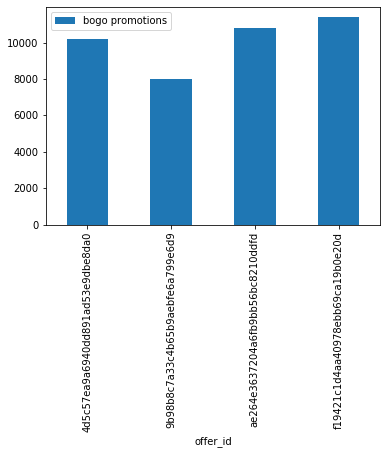

In [56]:
bogo_users.groupby('offer_id')['person'].count().plot(kind='bar', label = 'bogo promotions')
plt.legend()

bogo offer 'f19421c1d4aa40978ebb69ca19b0e20d' is the one has been offered mostly to the users.

In [57]:
bogo_users.groupby('person')['offer_id'].apply(lambda x: x.drop_duplicates()).value_counts()

4d5c57ea9a6940dd891ad53e9dbe8da0    4480
ae264e3637204a6fb9bb56bc8210ddfd    4473
f19421c1d4aa40978ebb69ca19b0e20d    4458
9b98b8c7a33c4b65b9aebfe6a799e6d9    3128
Name: offer_id, dtype: int64

In [58]:
bogo1=bogo_users.groupby('offer_id')['person'].count()
bogo2=bogo_users.groupby('person')['offer_id'].apply(lambda x: x.drop_duplicates()).value_counts()
Frequency =bogo1/bogo2
Frequency

4d5c57ea9a6940dd891ad53e9dbe8da0    2.279018
9b98b8c7a33c4b65b9aebfe6a799e6d9    2.558824
ae264e3637204a6fb9bb56bc8210ddfd    2.409345
f19421c1d4aa40978ebb69ca19b0e20d    2.552714
dtype: float64

We can see the average time each bogo promotion has been provided to the users. 9b98b8c7a33c4b65b9aebfe6a799e6d9 has the highest frequency in providing for a single user.

### Demographic characteristic of the users affected positively by bogo

In [59]:
# Merge the bogo users with the profile table
bogo_users_profile = pd.merge(
    bogo_users[["person","value"]],
    profile,
    how="inner", on=["person"])

bogo_users_profile.head()

,person,value,gender,age,became_member_on,income
0,454b00bdd77c4f588eb9f6cafd81dc5d,1015.73,F,53,20180329,89000.0
1,52959f19113e4241a8cb3bef486c6412,977.78,M,55,20161220,111000.0
2,52959f19113e4241a8cb3bef486c6412,35.86,M,55,20161220,111000.0
3,52959f19113e4241a8cb3bef486c6412,35.86,M,55,20161220,111000.0
4,52959f19113e4241a8cb3bef486c6412,35.86,M,55,20161220,111000.0


Text(0.5, 1.0, 'Age distribution')

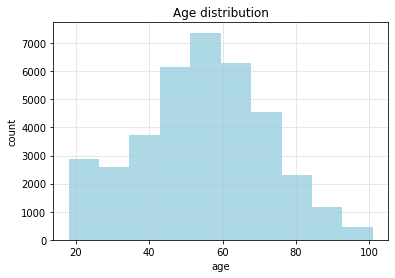

In [60]:
plt.hist(bogo_users_profile['age'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('age')
plt.ylabel('count')
plt.title('Age distribution')

The bogo affected users are mostly concentrated in 50 to 60 years old. There are also a big range of users until 70 years old.

Text(0.5, 1.0, 'Gender distribution')

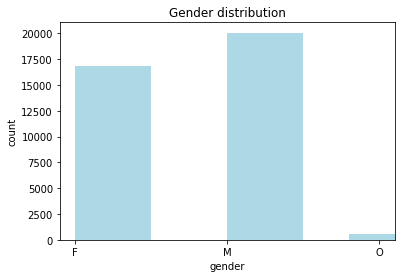

In [61]:
bogo_users_profile = bogo_users_profile[pd.notnull(bogo_users_profile['gender'])]
plt.hist(bogo_users_profile['gender'], color = 'lightblue', width=0.5)
plt.xlabel('gender')
plt.ylabel('count')
plt.title('Gender distribution')


In [62]:
bogo_users_profile.groupby('person')['gender'].apply(lambda x: x.drop_duplicates()).value_counts()

M    5901
F    4239
O     147
Name: gender, dtype: int64

Surprisingly, the amount of female users is quite close to the male users amount. Male users are 55%, Female are 43%, 2% did not define the gender.

Text(0.5, 1.0, 'Income distribution')

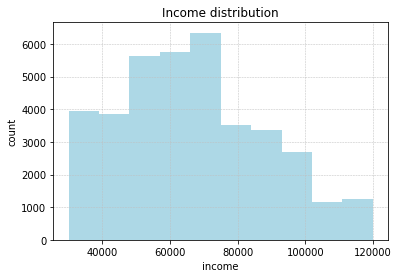

In [63]:
plt.hist(bogo_users_profile['income'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('income')
plt.ylabel('count')
plt.title('Income distribution')

The most outstanding income group is people who is earning 65k-75k.

Text(0.5, 1, 'Correlation of Gener,Age and Income')

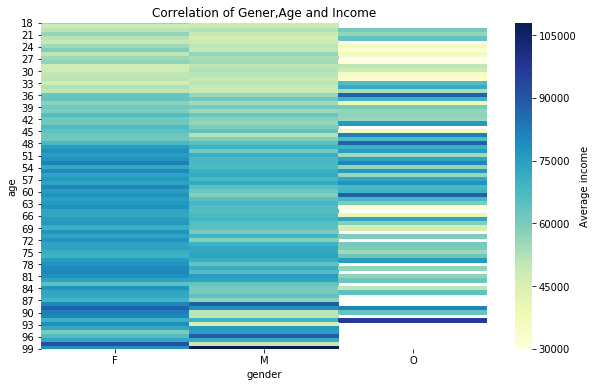

In [64]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(pd.crosstab(bogo_users_profile['age'],bogo_users_profile['gender'], values =bogo_users_profile['income'], aggfunc='mean'), 
                 cmap='YlGnBu',cbar_kws={'label': 'Average income'})
ax.set_title('Correlation of Gener,Age and Income')

Like the general tendency, the older female users earns higher salary, but the male users is not always in this case. it seems the 48-65 years old users have the most high salary dentisy.

### Top bogo buyers

In [65]:
bogo_users_profile.groupby('person')['value'].sum().sort_values(ascending = False).head(10)

person
c93f9619abd642a684bd79953cef992c    7070.96
4b72995c52ab4cd5ab407924b09e1ab4    4108.68
5dfdad4241764dfe959f51b7460e42b1    3867.36
3c8d541112a74af99e88abbd0692f00e    3377.36
7d7f271652d244f78b97c73cd734c553    3310.74
cea97a52bddc4a0e9c6c54f30c78253b    3202.94
633815975da245bb83537702f1ffa118    3184.45
e92c066a94254377a9d931033a4ae260    2974.42
df1e6d50effb4af28aff99f69fd3f394    2836.12
153f7ce19d8f4c8294fdc8d758c880c7    2632.89
Name: value, dtype: float64

There are top 10 users who have spent most of the money on buying starbucks after receiving the promotion

In [66]:
bogo_users_profile.groupby('person')['value'].count().sort_values(ascending = False).head(10)

person
073fce5708884b30a28b65b3cb15a919    81
c93f9619abd642a684bd79953cef992c    80
948ec827ac334c8782a1da99a2d6a39b    80
4b72995c52ab4cd5ab407924b09e1ab4    80
e7757d0a16384143ad9b2f9e429c23a9    76
db23badcb0e64c0eb193721a727a446f    73
894d620373384c5f8c25e28d15de7959    48
d3209835a40a423fbf2c967218d00bcd    46
42ef6b1a574d43e69750a3c7fd378ef4    46
c8f6b6d4decd48c1a81b6c8fcf567958    44
Name: value, dtype: int64

These are the top 10 users who most frecuently buy starbucks products.

### Revenue gained and cost per acquisition (CPA) from bogo offers

In [67]:
bogo_users['value'].sum()

664294.3

In [68]:
bogo_users.groupby('offer_id')['value'].sum()

offer_id
4d5c57ea9a6940dd891ad53e9dbe8da0    172687.13
9b98b8c7a33c4b65b9aebfe6a799e6d9    129167.78
ae264e3637204a6fb9bb56bc8210ddfd    173189.72
f19421c1d4aa40978ebb69ca19b0e20d    189249.67
Name: value, dtype: float64

In [69]:
bogo_users.groupby('offer_id')['value'].sum()/bogo_users.groupby('offer_id')['person'].count()

offer_id
4d5c57ea9a6940dd891ad53e9dbe8da0    16.913529
9b98b8c7a33c4b65b9aebfe6a799e6d9    16.137904
ae264e3637204a6fb9bb56bc8210ddfd    16.070309
f19421c1d4aa40978ebb69ca19b0e20d    16.630024
dtype: float64

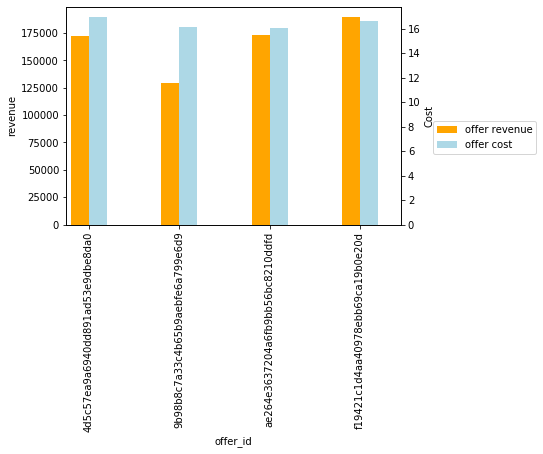

In [70]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
width = 0.2
bogo = bogo_users.groupby('offer_id')['value'].sum()
CPA_bogo = bogo_users.groupby('offer_id')['value'].sum()/bogo_users.groupby('offer_id')['person'].count()

bogo.plot(kind='bar', color='orange', ax=ax1, width=width, position=1, label = 'offer revenue')
CPA_bogo.plot(kind='bar', color='lightblue', ax=ax2, width=width, position=0, label = 'offer cost')

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1+handler2, label1+label2, loc='upper center', bbox_to_anchor=(1.25, 0.5))

ax1.set_ylabel('revenue')
ax2.set_ylabel('Cost')

plt.show()

f19421c1d4aa40978ebb69ca19b0e20d gained the most revenue, ae264e3637204a6fb9bb56bc8210ddfd has the lowest CPA.

## Users affected positively by discount

In [71]:
# Lets choose when the promotion is discount
discount_users = positive_users_promotion(receive_completed_trans, 'discount')
discount_users.head()

,person,offer_id,receive_day,offer_type,duration,complete_day,reward,transaction_day,value,reaction_time
50562,5ecaea5c8bf44ae4a65838d9d066c909,fafdcd668e3743c1bb461111dcafc2a4,0.0,discount,10.0,0.25,2.0,4.25,1001.85,4.25
117627,dce784e26f294101999d000fad9089bb,fafdcd668e3743c1bb461111dcafc2a4,21.0,discount,10.0,15.50,2.0,15.50,989.34,-5.50
117622,dce784e26f294101999d000fad9089bb,fafdcd668e3743c1bb461111dcafc2a4,21.0,discount,10.0,1.75,2.0,15.50,989.34,-5.50
117616,dce784e26f294101999d000fad9089bb,fafdcd668e3743c1bb461111dcafc2a4,14.0,discount,10.0,23.25,2.0,15.50,989.34,1.50
117611,dce784e26f294101999d000fad9089bb,fafdcd668e3743c1bb461111dcafc2a4,14.0,discount,10.0,15.50,2.0,15.50,989.34,1.50


In [72]:
discount_users['person'].drop_duplicates().count()

10999

There are 2497 unique users have been provided the discount promotion.

In [73]:
discount_users.groupby('offer_id')['person'].count()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7     4875
2298d6c36e964ae4a3e7e9706d1fb8c2    14296
2906b810c7d4411798c6938adc9daaa5     7672
fafdcd668e3743c1bb461111dcafc2a4    15311
Name: person, dtype: int64

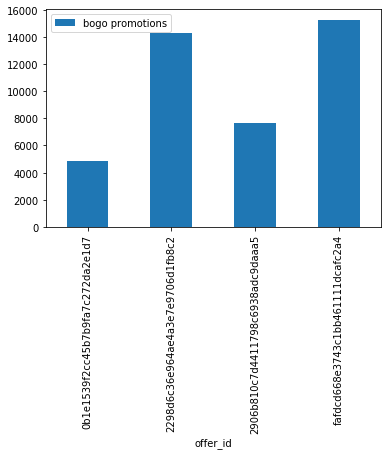

In [74]:
discount_users.groupby('offer_id')['person'].count().plot(kind='bar', label = 'bogo promotions')
plt.legend()

In [75]:
discount_users.groupby('person')['offer_id'].apply(lambda x: x.drop_duplicates()).value_counts()

fafdcd668e3743c1bb461111dcafc2a4    5034
2298d6c36e964ae4a3e7e9706d1fb8c2    4875
2906b810c7d4411798c6938adc9daaa5    2955
0b1e1539f2cc45b7b9fa7c272da2e1d7    2139
Name: offer_id, dtype: int64

In [76]:
discount1=discount_users.groupby('offer_id')['person'].count()
discount2=discount_users.groupby('person')['offer_id'].apply(lambda x: x.drop_duplicates()).value_counts()
Frequency_discount =discount1/discount2
Frequency_discount

0b1e1539f2cc45b7b9fa7c272da2e1d7    2.279102
2298d6c36e964ae4a3e7e9706d1fb8c2    2.932513
2906b810c7d4411798c6938adc9daaa5    2.596277
fafdcd668e3743c1bb461111dcafc2a4    3.041518
dtype: float64

fafdcd668e3743c1bb461111dcafc2a4 has been provided for each users almost 3 times. Comparing with bogo promotion, discount have been offered more than bogo promotion.

### Demographic characteristic of the users affected positively by discount

In [77]:
discount_users_profile = pd.merge(
    discount_users[["person","value"]],
    profile,
    how="inner", on=["person"])

Text(0.5, 1.0, 'Age distribution')

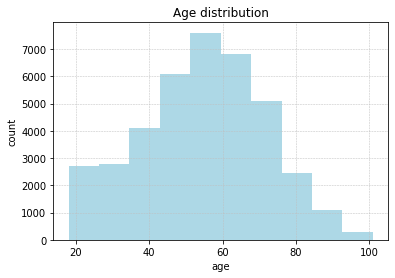

In [80]:
plt.hist(discount_users_profile['age'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('age')
plt.ylabel('count')
plt.title('Age distribution')

Text(0.5, 1.0, 'Gender distribution')

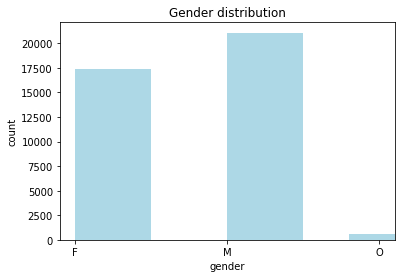

In [81]:
discount_users_profile = discount_users_profile[pd.notnull(discount_users_profile['gender'])]
plt.hist(discount_users_profile['gender'], color = 'lightblue', width=0.5)
plt.xlabel('gender')
plt.ylabel('count')
plt.title('Gender distribution')

In [82]:
discount_users_profile.groupby('person')['gender'].apply(lambda x: x.drop_duplicates()).value_counts()

M    5479
F    4073
O     143
Name: gender, dtype: int64

Text(0.5, 1.0, 'Income distribution')

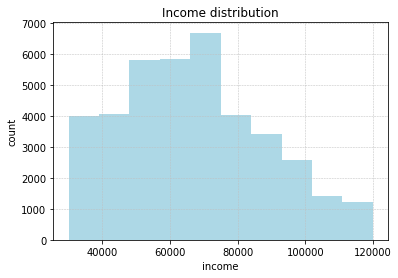

In [83]:
plt.hist(discount_users_profile['income'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('income')
plt.ylabel('count')
plt.title('Income distribution')

Text(0.5, 1, 'Correlation of Gener,Age and Income')

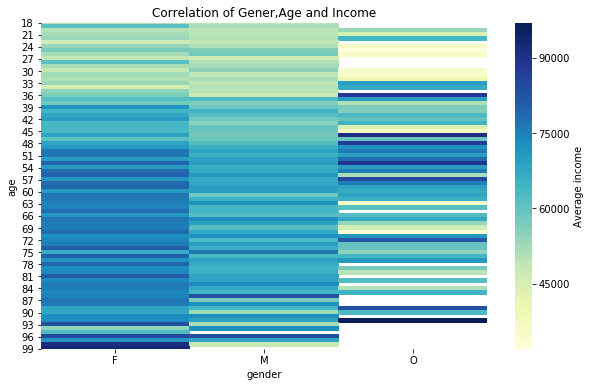

In [84]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(pd.crosstab(discount_users_profile['age'],discount_users_profile['gender'], values =discount_users_profile['income'], aggfunc='mean'), 
                 cmap='YlGnBu',cbar_kws={'label': 'Average income'})
ax.set_title('Correlation of Gener,Age and Income')

From here you can see, comparing with the Bogo users, female discount users have higher salary level than the bogo female users. And the males users in discount group have average lower salary than female users.

### Top discount buyers

In [85]:
discount_users_profile.groupby('person')['value'].sum().sort_values(ascending = False).head(10)

person
dce784e26f294101999d000fad9089bb    6523.59
1c05e4a68fc04d3da27454cb7eaa6144    3605.48
0a7c7af5e814481b8e4a4a3b6e2f8697    2990.28
8d31a8a4b5d24b10a54da118855f7132    2935.04
c35d2009f1a1434fb4f59658f14ad0ec    2599.56
8807861d85f24d7c8d888f33e96d940e    2443.46
73afdeca19e349b98f09e928644610f8    2259.87
281d463f31e74ecaa4451d169868c5d7    2092.76
8a776d222f174aa089866b2725721eec    1960.70
1c8cf4af93464dcaa971cfcffc2cc1e5    1921.60
Name: value, dtype: float64

In [86]:
discount_users_profile.groupby('person')['value'].count().sort_values(ascending = False).head(10)

person
281d463f31e74ecaa4451d169868c5d7    96
bd2cdd691aca4bb0a0e039979ee5de5c    90
ac3b8c9879304a9db841fa510d931ea7    89
ea54840ba8a54a098de60d39fc533d51    84
edc7b04392144da9979f3077095f268a    72
1c8cf4af93464dcaa971cfcffc2cc1e5    68
eab78e2cf26f4af494d9535ac3835f00    66
96ae94b7eb5e404bbe7a5fe07a7d7035    55
72412f41d944472dbba2183ae9af8a8e    50
b063b99c5a96415f9837a54ba030d735    48
Name: value, dtype: int64

### Revenue gained and cost per acquisition (CPA) from discount offers

In [87]:
discount_users['value'].sum()

670906.29

In [88]:
discount_users.groupby('offer_id')['value'].sum()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7     86903.17
2298d6c36e964ae4a3e7e9706d1fb8c2    209562.98
2906b810c7d4411798c6938adc9daaa5    134793.65
fafdcd668e3743c1bb461111dcafc2a4    239646.49
Name: value, dtype: float64

In [89]:
discount_users.groupby('offer_id')['value'].sum()/discount_users.groupby('offer_id')['person'].count()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    17.826291
2298d6c36e964ae4a3e7e9706d1fb8c2    14.658854
2906b810c7d4411798c6938adc9daaa5    17.569558
fafdcd668e3743c1bb461111dcafc2a4    15.651916
dtype: float64

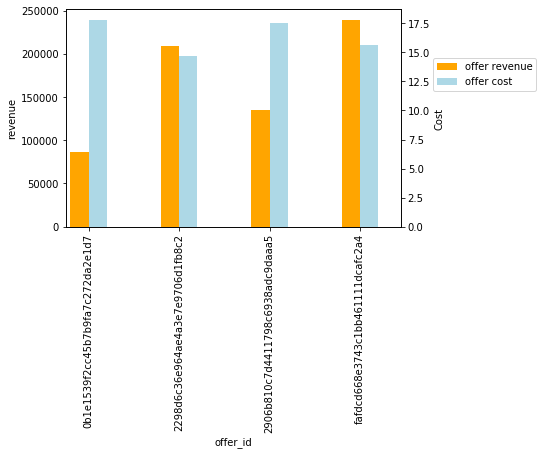

In [90]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
width = 0.2
disc = discount_users.groupby('offer_id')['value'].sum()
CPA_disc = discount_users.groupby('offer_id')['value'].sum()/discount_users.groupby('offer_id')['person'].count()

disc.plot(kind='bar', color='orange', ax=ax1, width=width, position=1, label = 'offer revenue')
CPA_disc.plot(kind='bar', color='lightblue', ax=ax2, width=width, position=0, label = 'offer cost')

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1+handler2, label1+label2, loc='upper center', bbox_to_anchor=(1.25, 0.8))

ax1.set_ylabel('revenue')
ax2.set_ylabel('Cost')

plt.show()

fafdcd668e3743c1bb461111dcafc2a4 gained the highest revenue, but 2298d6c36e964ae4a3e7e9706d1fb8c2 has the lowest CPA, which is better.

## Users affected positively by informational offer

In [91]:
informational_users = positive_users_promotion(receive_completed_trans, 'informational')
informational_users.head()

,person,offer_id,receive_day,offer_type,duration,complete_day,reward,transaction_day,value,reaction_time
64972,7a153a17d9754d3686c37684146fb681,5a8bc65990b245e5a138643cd4eb9837,21.0,informational,3.0,NaN,NaN,12.00,855.31,-9.00
111624,d17651704645434c91e0758290ef14b0,3f207df678b143eea3cee63160fa8bed,21.0,informational,4.0,NaN,NaN,23.75,746.52,2.75
119533,e0570660882b49db860b43f704e5590b,5a8bc65990b245e5a138643cd4eb9837,21.0,informational,3.0,NaN,NaN,14.50,725.99,-6.50
119523,e0570660882b49db860b43f704e5590b,5a8bc65990b245e5a138643cd4eb9837,14.0,informational,3.0,NaN,NaN,14.50,725.99,0.50
88697,a5cde6ee9df740b5afd639bb94a007ba,5a8bc65990b245e5a138643cd4eb9837,24.0,informational,3.0,NaN,NaN,25.50,644.85,1.50


In [92]:
informational_users['person'].drop_duplicates().count()

4844

In [93]:
informational_users.groupby('offer_id')['person'].count()

offer_id
3f207df678b143eea3cee63160fa8bed    2626
5a8bc65990b245e5a138643cd4eb9837    4297
Name: person, dtype: int64

In [94]:
informational_users.groupby('person')['offer_id'].apply(lambda x: x.drop_duplicates()).value_counts()

5a8bc65990b245e5a138643cd4eb9837    3190
3f207df678b143eea3cee63160fa8bed    2006
Name: offer_id, dtype: int64

In [95]:
informational1=informational_users.groupby('offer_id')['person'].count()
informational2=informational_users.groupby('person')['offer_id'].apply(lambda x: x.drop_duplicates()).value_counts()
Frequency_informational =informational1/informational2
Frequency_informational

3f207df678b143eea3cee63160fa8bed    1.309073
5a8bc65990b245e5a138643cd4eb9837    1.347022
dtype: float64

### Demographic characteristic of the users affected positively by informational offers

In [96]:
informational_users_profile = pd.merge(
    informational_users[["person","value"]],
    profile,
    how="inner", on=["person"])

Text(0.5, 1.0, 'Age distribution')

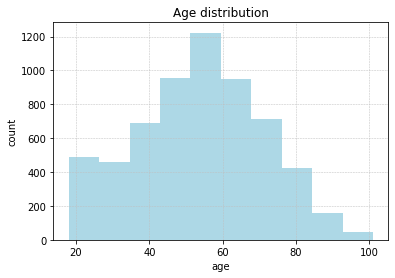

In [97]:
plt.hist(informational_users_profile['age'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('age')
plt.ylabel('count')
plt.title('Age distribution')

Text(0.5, 1.0, 'Gender distribution')

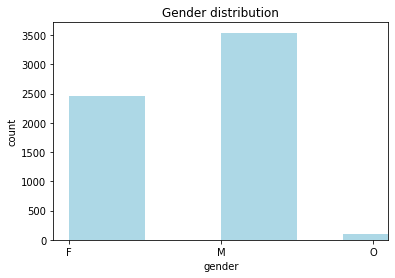

In [98]:
informational_users_profile = informational_users_profile[pd.notnull(informational_users_profile['gender'])]
plt.hist(informational_users_profile['gender'], color = 'lightblue', width=0.5)
plt.xlabel('gender')
plt.ylabel('count')
plt.title('Gender distribution')

In [99]:
informational_users_profile.groupby('person')['gender'].apply(lambda x: x.drop_duplicates()).value_counts()

M    2462
F    1738
O      67
Name: gender, dtype: int64

Text(0.5, 1.0, 'Income distribution')

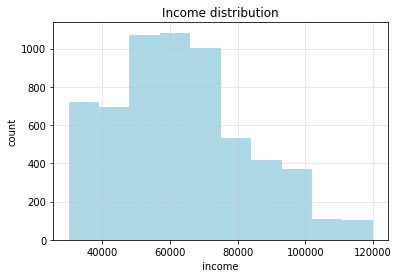

In [100]:
plt.hist(informational_users_profile['income'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('income')
plt.ylabel('count')
plt.title('Income distribution')

Text(0.5, 1, 'Correlation of Gener,Age and Income')

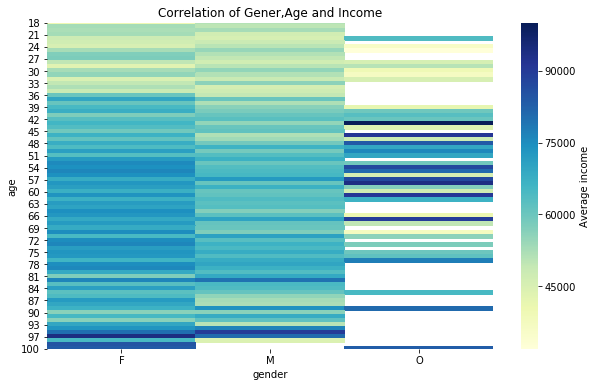

In [101]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(pd.crosstab(informational_users_profile['age'],informational_users_profile['gender'], values =informational_users_profile['income'], aggfunc='mean'), 
                 cmap='YlGnBu',cbar_kws={'label': 'Average income'})
ax.set_title('Correlation of Gener,Age and Income')

This group of users is very similar to bogo users. But still the female users have higher salary level than male users.

### Top informational users

In [102]:
informational_users.groupby('person')['value'].sum().sort_values(ascending = False).head(10)

person
e0570660882b49db860b43f704e5590b    1467.94
7a153a17d9754d3686c37684146fb681     902.94
d17651704645434c91e0758290ef14b0     840.98
8d5dc8f536bb487e9d5c72db1367b1d2     723.49
a5cde6ee9df740b5afd639bb94a007ba     644.85
fbfd90953e754794ac3323c43881992d     638.84
35055ff4289447df8c93739196163b01     565.00
38feae8a6b564476977e348198ed57b5     552.43
645bdee43b0f43899320fcb0b427084c     537.26
56a02aabb8cb4568b9b86998c0b5369c     487.47
Name: value, dtype: float64

In [103]:
informational_users.groupby('person')['value'].count().sort_values(ascending = False).head(10)

person
23d67a23296a485781e69c109a10a1cf    14
dca5e3cb4b4a4a399933444bc2a1fbd5    10
d2678b66cabe423390376ece655685c0    10
6dba14f698ae4030ab7354cd5cfe7119     9
5d6fe66ee0764083ba82abc7af9f7a97     9
f531c0be9e534920a98dc74e317b56ef     8
eece6a9a7bdd4ea1b0f812f34fc619d6     8
573be1fbaa5c459a9644e10e1ebb07a0     7
6683f9a3e9344658ba4d8776410086e6     7
f08841c728214233b3b5c284cc5b07a1     7
Name: value, dtype: int64

### Revenue gained and cost per acquisition (CPA) from informational offers

In [104]:
informational_users['value'].sum()

93599.33

In [105]:
informational_users.groupby('offer_id')['value'].sum()

offer_id
3f207df678b143eea3cee63160fa8bed    40354.01
5a8bc65990b245e5a138643cd4eb9837    53245.32
Name: value, dtype: float64

In [106]:
informational_users.groupby('offer_id')['value'].sum()/informational_users.groupby('offer_id')['person'].count()

offer_id
3f207df678b143eea3cee63160fa8bed    15.367102
5a8bc65990b245e5a138643cd4eb9837    12.391278
dtype: float64

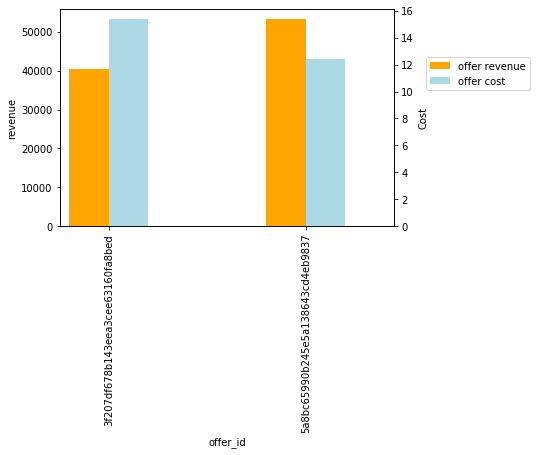

In [107]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
width = 0.2
informational = informational_users.groupby('offer_id')['value'].sum()
CPA_info = informational_users.groupby('offer_id')['value'].sum()/informational_users.groupby('offer_id')['person'].count()

informational.plot(kind='bar', color='orange', ax=ax1, width=width, position=1, label = 'offer revenue')
CPA_info.plot(kind='bar', color='lightblue', ax=ax2, width=width, position=0, label = 'offer cost')

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1+handler2, label1+label2, loc='upper center', bbox_to_anchor=(1.25, 0.8))

ax1.set_ylabel('revenue')
ax2.set_ylabel('Cost')

plt.show()

### Users who have been provided by more than 1 type of offers

#### Users who have been influenced by 1 type of offer.

In [108]:
offer1type = receive_completed_trans.loc[receive_completed_trans.groupby('person').offer_type.filter(
    lambda x: x.nunique()==1).index]

In [109]:
offer1type['person'].drop_duplicates().count()

1019

In [110]:
offer1type['value'].sum()

133794.71

In [111]:
offer1type.groupby('offer_type')['value'].sum()

offer_type
bogo             61515.36
discount         70414.39
informational     1864.96
Name: value, dtype: float64

#### Users who have been influenced by 2 types of offer.

In [112]:
# Select the users who have been served more than 1 types of offers.
offer2type = receive_completed_trans.loc[receive_completed_trans.groupby('person').offer_type.filter(
    lambda x: x.nunique()==2).index]

In [113]:
offer2type['person'].drop_duplicates().count()

8460

In [114]:
offer2type['value'].sum()

942824.36

In [115]:
offer2type.groupby('offer_type')['value'].sum()

offer_type
bogo             461711.00
discount         429907.21
informational     51206.15
Name: value, dtype: float64

#### Users who have been influenced by 3 types of offer.

In [116]:
offer3type = receive_completed_trans.loc[receive_completed_trans.groupby('person').offer_type.filter(
    lambda x: x.nunique()>2).index]

In [117]:
offer3type['person'].drop_duplicates().count()

7515

In [118]:
offer3type['value'].sum()

674019.96

In [119]:
offer3type.groupby('offer_type')['value'].sum()

offer_type
bogo             303252.52
discount         287475.77
informational     83291.67
Name: value, dtype: float64

#### Comparison

In [120]:
comparison_3types = pd.DataFrame({'offer type': ['1 type', '2 types', '3 types'], 'revenue':[133794, 942824, 674019], 
                                  'users':[1019, 8460, 7515]})

comparison_3types['revenue per user'] = comparison_3types['revenue']/comparison_3types['users']

In [121]:
comparison_3types

,offer type,revenue,users,revenue per user
0,1 type,133794,1019,131.299313
1,2 types,942824,8460,111.444917
2,3 types,674019,7515,89.689820


From this comparison you can see when there are 2 types of offers are provided, there are most revenue, and 50% of users are provided by 2 types of offers, 44% of users are provided by 3 types of offers, and 6% of the users are provided by only 1 type of offer. You can also see that the more types are offered, the lower revenue per user is. In general, the 2 types offers are most recommendable, it generated high revenue, provided the wider users and also have a good revenue per user. 

### Demographich comparison between different promotion user groups

In [122]:
def plot_hist(variable,bins=None):
    plt.hist(discount_users_profile[variable],alpha=0.5, label='discount users',bins=bins)
    plt.hist(bogo_users_profile[variable], alpha=0.5, label='bogo users',bins=bins)
    plt.hist(informational_users_profile[variable], alpha=0.5, label='informational users',bins=bins)
    plt.legend(loc='upper right')
    plt.title('distribution of '+ variable + ' between different promotion users')
    plt.show()

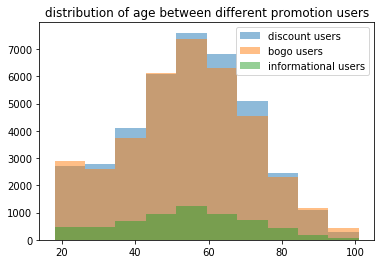

In [123]:
plot_hist('age')

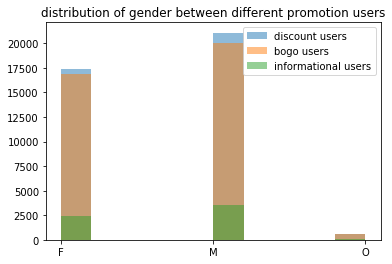

In [124]:
plot_hist('gender')

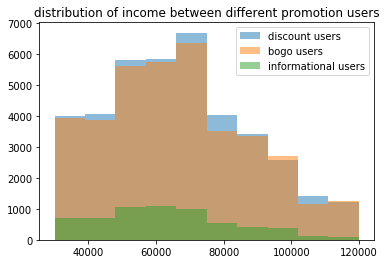

In [125]:
plot_hist('income')

In general, there are more discount users than another 2 types of users. The profile within these 3 groups are quite similar.

## Group 2: customers not effected by promotions

To find out the customers who are not effected by the promotion will help us to switch our strategy or also find the reason why these people are not affected, see their profile, what type of demographic characteristics they have.

**Define group 2**

- Behaviors 1: Offer received 
- Behaviors 2: Offer received - offer viewed


In [126]:
# List the person who have made the transaction
transaction_users = set(transcript_total[(transcript_total['event'] == 'transaction')]['person'])

In [127]:
len(transaction_users)

16578

In [128]:
received_users = set(transcript_total[(transcript_total['event'] == 'offer received')]['person'])

In [129]:
len(received_users)

16994

In [130]:
users_no_transaction = received_users - transaction_users

In [131]:
len(users_no_transaction)

422

In [132]:
users_no_transaction = list(users_no_transaction)
users_no_transaction[:10]

['c9fe2208e4da432898d61a0340743613',
 '456f5d7fe4f14732b01a85b3a584ab82',
 'aee8cae3f1a345128f3b3612e4d529dd',
 'f12407b8b57341bc8485757508874811',
 'cf7ca63f868f4ca2b8c0114081382ec2',
 'b8089791382345409b4b0c090f67125e',
 'a34274d200d74984a02fc713392c8e01',
 'd332bcf1498e45d79bcfda75abbefd04',
 '43fad197697347f88bd70d89421b5030',
 'b56ba454203b495e969482b3785727da']

There are 422 users were not affected by the offers. Here is a list of the users who received the offer but did not make any transaction. They are the users not effeciently affected by the offers.

### Demographic characteristic of customers not affected by the offer

In [133]:
users_no_transaction_profile = transcript_total.loc[transcript_total['person'].isin(users_no_transaction)]

Text(0.5, 1.0, 'Age distribution')

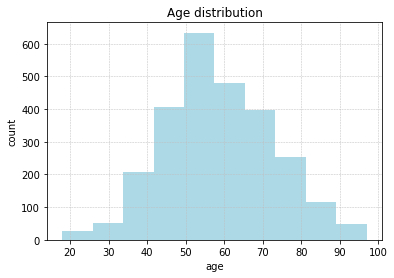

In [134]:
users_no_transaction_profile = users_no_transaction_profile[pd.notnull(users_no_transaction_profile['age'])]
plt.hist(users_no_transaction_profile['age'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('age')
plt.ylabel('count')
plt.title('Age distribution')

Text(0.5, 1.0, 'Gender distribution')

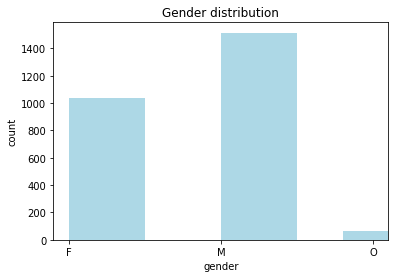

In [135]:
users_no_transaction_profile = users_no_transaction_profile[pd.notnull(users_no_transaction_profile['gender'])]
plt.hist(users_no_transaction_profile['gender'], color = 'lightblue', width=0.5)
plt.xlabel('gender')
plt.ylabel('count')
plt.title('Gender distribution')

In [136]:
users_no_transaction_profile.groupby('person')['gender'].apply(lambda x: x.drop_duplicates()).value_counts()

M    189
F    136
O      8
Name: gender, dtype: int64

Text(0.5, 1.0, 'Income distribution')

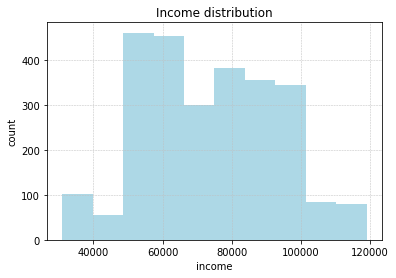

In [137]:
plt.hist(users_no_transaction_profile['income'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('income')
plt.ylabel('count')
plt.title('Income distribution')

Text(0.5, 1, 'Correlation of Gener,Age and Income')

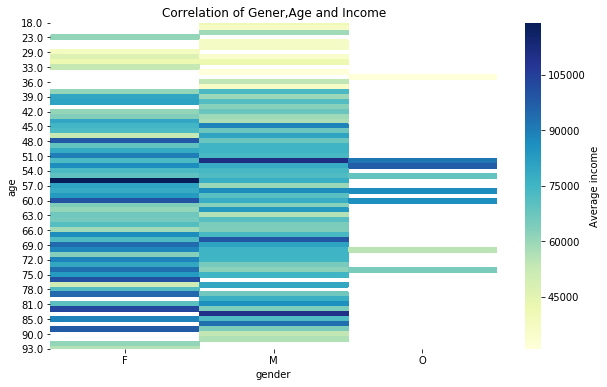

In [138]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(pd.crosstab(users_no_transaction_profile['age'],users_no_transaction_profile['gender'], values =users_no_transaction_profile['income'], aggfunc='mean'), 
                 cmap='YlGnBu',cbar_kws={'label': 'Average income'})
ax.set_title('Correlation of Gener,Age and Income')

Users who are not affected by the offer are concentrated with 50-58 years old, 56% are male, 41% are female. Income level is mostly in 50 -65k. The profile between male and females is quite similar.

## Group 3: loyal customers (buy Starbucks anyway)

In this part, I will analyze the users who will not be affected by the promotion, who are the ones will buy starbuck product anyway. To find out these users, we can save our promotion cost on them, we might not need to give the promotion to them or even use different strategy to bond them.

**Define group 3**

- Behaviors 1: transaction - offer received
- Behaviors 2: transaction - offer received - offer viewed
- Behaviors 3: offer received - transaction
- Behaviors 4: offer received - transaction - offer viewed

In [139]:
viewed_users = set(transcript_total[(transcript_total['event'] == 'offer viewed')]['person'])

In [140]:
len(viewed_users)

16834

In [141]:
# Find who did not view the offer but still made the transaction
loyal_customers = transaction_users - viewed_users

In [142]:
len(loyal_customers)

156

In [143]:
loyal_customers = list(loyal_customers)
loyal_customers[:10]

['daa6d5470e2a4d52b30e6943275722d9',
 '3622ea602ea242a68bf3bf73df66bbb9',
 '6613c82a3acd4cbca267d7b056b35780',
 '5c851531055e412395def06f0dae03b3',
 '2e9660f6e83b49bbb9d533b9317359c4',
 '9acbb111ba2f452cbbafabaf49138377',
 '50af182d9e074539b7d6ed8035e1e16e',
 '54a7bb02e8e84d028346d004cc461224',
 'b860d355ef6e4c66b5d5a837c56ef32d',
 '12ede229379747bd8d74ccdc20097ca3']

### Demographic characteristic of loyal customers 

In [144]:
loyal_customer_profile = transcript_total.loc[transcript_total['person'].isin(loyal_customers)]

Text(0.5, 1.0, 'Age distribution')

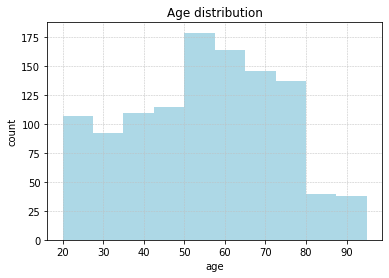

In [145]:
loyal_customer_profile = loyal_customer_profile[pd.notnull(loyal_customer_profile['age'])]
plt.hist(loyal_customer_profile ['age'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('age')
plt.ylabel('count')
plt.title('Age distribution')

Text(0.5, 1.0, 'Gender distribution')

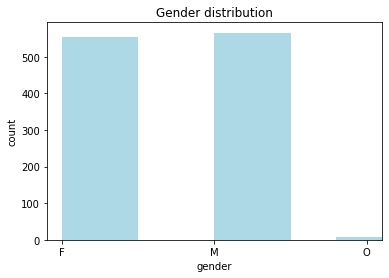

In [146]:
loyal_customer_profile = loyal_customer_profile[pd.notnull(loyal_customer_profile['gender'])]
plt.hist(loyal_customer_profile['gender'], color = 'lightblue', width=0.5)
plt.xlabel('gender')
plt.ylabel('count')
plt.title('Gender distribution')

In [147]:
loyal_customer_profile.groupby('person')['gender'].apply(lambda x: x.drop_duplicates()).value_counts()

M    74
F    65
O     1
Name: gender, dtype: int64

Text(0.5, 1.0, 'Income distribution')

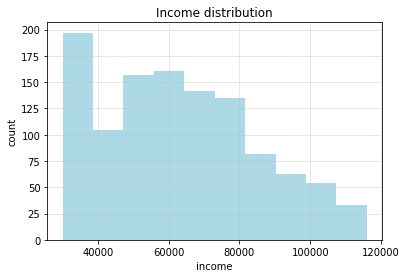

In [148]:
plt.hist(loyal_customer_profile['income'], color = 'lightblue')
plt.grid(True, lw = 0.5, ls = '--', c = '.75')
plt.xlabel('income')
plt.ylabel('count')
plt.title('Income distribution')

That is very interesting to see that the most of the starbuck loyal customers do not have a very high income. They mainly gain in 32k - 40k dollars annually.  

Text(0.5, 1, 'Correlation of Gener,Age and Income')

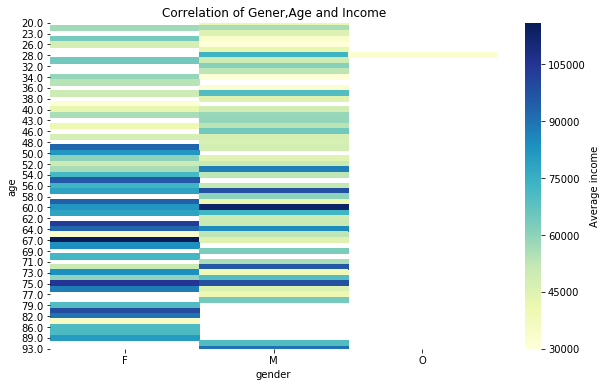

In [149]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(pd.crosstab(loyal_customer_profile['age'],loyal_customer_profile['gender'], values =loyal_customer_profile['income'], aggfunc='mean'), 
                 cmap='YlGnBu',cbar_kws={'label': 'Average income'})
ax.set_title('Correlation of Gener,Age and Income')

Within all the loyal customers, the female users definitely have the higher economic power since they have higher average salary, almost of the male users do not have high income, whatever how old they are. But the female users have higher income with older ages.

# 2. Training Data and Models

Before starting to train the models, we need to think the following questions:

- What do we want to predict?
- What type of data is? Labeled data or unlabeled data? (To help us to choose either supervised learning or unsupervised learning).
- What type of algorithms we can use? Categorical or numerical?
- What algorithms are better for this type of data/models?

In starbuck case, what I like to predict is **whether the promotion offer will be efficient for certain users.** It is a **binary classification problem.**

The target will be the **efficient offer**.

The features to train will be the **other features in the data, include the users demographic characteristics and also the offer duration, type, offer channels, etc**.

I defined the dataset as labeled data, so we will use supervised learning models.

What I want to predict is a categorical form, will be YES or NO, 1 or 0.

#### Choose Models:

The algorithms we can use in this case can be:

- Decision Tree model
- Random forest model
- Gradient boosting model
- Adaboost model

#### Choose Metrics:

After training these models, we need some cross validation metrics to test the model performance, to see whether this model is working fine. Since this is binary classification problem, what I like to use to measure the models are the following:

- AUC (Area under curve), is a performance measurement for classification problem at various thresholds settings. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. But when the AUC is almost 1, the model can be overfitting as well.
- Accuracy, forclassification problems is the number of correct predictions made by the model over all kinds predictions made.
- Precision, is the result of True Positive/(True Positive + False Positive), the higher precision is, the better model is to predice how precise is.
- F1 score, is a single score that kind of represents both Precision(P) and Recall(R), F1 Score = 2 * Precision * Recall / (Precision + Recall)

In [150]:
# Create one column add the effective_offer column
receive_completed_trans['effective_offer']=np.where((receive_completed_trans['duration']>
                                                     receive_completed_trans['transaction_day']-
                                                     receive_completed_trans['receive_day']),1,0)

In [151]:
receive_completed_trans.head()

,person,offer_id,receive_day,offer_type,duration,complete_day,reward,transaction_day,value,effective_offer
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,informational,3.0,NaN,NaN,9.5,22.16,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,informational,4.0,NaN,NaN,NaN,NaN,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,bogo,5.0,17.25,5.0,NaN,NaN,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,discount,10.0,22.00,2.0,23.0,13.56,1
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,discount,7.0,24.00,2.0,27.5,12.36,1


In [152]:
data_for_models = pd.merge(
    receive_completed_trans[['person', 'offer_id', 'effective_offer']],
    transcript_total,
    how="left", on=["person", "offer_id"])

# Remove the event is transaction, because there are a lot of None value in the rows
data_for_models = data_for_models[(data_for_models['event'] != 'transaction')]
data_for_models.head()

,person,offer_id,effective_offer,event,value,days,gender,age,became_member_on,income,...,transaction,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,offer received,0.0,7.0,M,33.0,20170421.0,72000.0,...,0,0.0,0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,offer viewed,0.0,8.0,M,33.0,20170421.0,72000.0,...,0,0.0,0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,offer received,0.0,14.0,M,33.0,20170421.0,72000.0,...,0,0.0,0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
4,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,offer viewed,0.0,15.5,M,33.0,20170421.0,72000.0,...,0,0.0,0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
5,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,offer received,0.0,17.0,M,33.0,20170421.0,72000.0,...,0,5.0,5.0,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0


In [153]:
data_for_models.shape

(594955, 23)

In [154]:
(data_for_models.isnull().sum())/data_for_models.shape[0]

person              0.00000
offer_id            0.00000
effective_offer     0.00000
event               0.00000
value               0.00000
days                0.00000
gender              0.06745
age                 0.06745
became_member_on    0.06745
income              0.06745
offer completed     0.00000
offer received      0.00000
offer viewed        0.00000
transaction         0.00000
reward              0.00000
difficulty          0.00000
duration            0.00000
offer_type          0.00000
id                  0.00000
email               0.00000
mobile              0.00000
social              0.00000
web                 0.00000
dtype: float64

Remember to be able to train the data into machine learning models, the data cannot contain None data. There are only age, gender, become_member_on and income column have None value, the missing value is only 6% of the whole data, so instead of filling them with mode or average value, I prefer to drop them.

In [155]:
data_for_models=data_for_models.dropna()
data_for_models.shape

(554825, 23)

In [156]:
# Dummy the categorical data into the numerical data
data_for_models = pd.concat([data_for_models,pd.get_dummies(data_for_models[['gender', 'offer_type']])],axis=1)

Remember when we want to train a model of categorical data, we will need to encode them into numerical data, then you can train the regression.

In [157]:
data_to_drop = ['person','offer_id','id','event','offer_type','gender','became_member_on']
data_for_models = data_for_models.drop(columns = data_to_drop, axis =1)

In [158]:
# define the data we want to predict and the features data
target = data_for_models['effective_offer']
features = data_for_models.drop('effective_offer', axis =1)

In [159]:
#prepare model pipeline
def data_split(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [160]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("AUC: %.4f" % auc(false_positive_rate, true_positive_rate))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [161]:
X_train, X_test, y_train, y_test=data_split(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
Model1 = DecisionTreeClassifier()

train_predict(Model1, X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 443860 samples.
MSE_train: 0.1739
MSE_test: 0.2639
AUC: 0.6032
Training accuracy:0.8261
Test accuracy:0.7361
              precision    recall  f1-score   support

           0     0.5541    0.3005    0.3897     31105
           1     0.7688    0.9058    0.8317     79860

    accuracy                         0.7361    110965
   macro avg     0.6614    0.6032    0.6107    110965
weighted avg     0.7086    0.7361    0.7078    110965



{'train_time': 5.840984106063843,
 'pred_time': 0.6454424858093262,
 'training_score': 0.8261231018789709,
 'testing_score': 0.7361420267651962}

In [162]:
Model2 = RandomForestClassifier()

train_predict(Model2, X_train, y_train, X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 443860 samples.
MSE_train: 0.1778
MSE_test: 0.2683
AUC: 0.5857
Training accuracy:0.8222
Test accuracy:0.7317
              precision    recall  f1-score   support

           0     0.5460    0.2535    0.3462     31105
           1     0.7594    0.9179    0.8312     79860

    accuracy                         0.7317    110965
   macro avg     0.6527    0.5857    0.5887    110965
weighted avg     0.6996    0.7317    0.6953    110965



{'train_time': 15.654465675354004,
 'pred_time': 5.663344144821167,
 'training_score': 0.8222051998377867,
 'testing_score': 0.7316631370251881}

In [163]:
Model3 = GradientBoostingClassifier()

train_predict(Model3, X_train, y_train, X_test, y_test)

GradientBoostingClassifier trained on 443860 samples.
MSE_train: 0.2675
MSE_test: 0.2681
AUC: 0.5363
Training accuracy:0.7325
Test accuracy:0.7319
              precision    recall  f1-score   support

           0     0.6562    0.0912    0.1602     31105
           1     0.7349    0.9814    0.8405     79860

    accuracy                         0.7319    110965
   macro avg     0.6956    0.5363    0.5003    110965
weighted avg     0.7129    0.7319    0.6498    110965



{'train_time': 124.37665486335754,
 'pred_time': 2.773866891860962,
 'training_score': 0.732544045419727,
 'testing_score': 0.7318613977380255}

In [164]:
Model4 = AdaBoostClassifier()

train_predict(Model4, X_train, y_train, X_test, y_test)

AdaBoostClassifier trained on 443860 samples.
MSE_train: 0.2720
MSE_test: 0.2730
AUC: 0.5289
Training accuracy:0.7280
Test accuracy:0.7270
              precision    recall  f1-score   support

           0     0.6009    0.0780    0.1381     31105
           1     0.7318    0.9798    0.8378     79860

    accuracy                         0.7270    110965
   macro avg     0.6663    0.5289    0.4880    110965
weighted avg     0.6951    0.7270    0.6417    110965



{'train_time': 47.514782190322876,
 'pred_time': 13.714154481887817,
 'training_score': 0.7279795430991755,
 'testing_score': 0.7270310458252602}

I tried to use 4 different models to see which models works better.

According to the training, testing accuracy, the AUC, and f1 score, I think we decision tree model and random forest model both work better on this case. 

But this result is still not as high as I expect, the higest accuracy is only 0.8293 (decision tree classifier) while the the precision and f1 score is only sligtly more than 0.7. Which is not ideal. So, to be able to increase the model performance, the way we can do is, adjust the parameters of the models.

As I said that the Decision Tree and Random Forest models work better in this case, I will select this both models to tone them by adjust their parameters.

## Tone the Model

As we just discussed, the accuracy of these models are not ideal, to increase the accuracy of the models, we need to tone it.

There are several ways to do it, I will show in my analysis.

1. Reduce the dimensionality

We will have a lot of dimensionalities, we can also say, features. When there are many features, the model can become very complex. **The more the number of features, the more the chances of overfitting.** A machine learning model that is trained on a large number of features, gets increasingly dependent on the data it was trained on and in turn overfitted, resulting in poor performance on real data, beating the purpose. There are so many advantage can be mentioned by using dimensionality reduction.

- Avoiding overfitting is a major motivation for performing dimensionality reduction. 
- Less misleading data means model accuracy improves. This is exactly what we need right now for this case, we want to increase the accuracy of our models.
- Less data means less storage space required.
- Less dimensions mean less computing. Less data means that algorithms train faster.
- Less dimensions allow usage of algorithms unfit for a large number of dimensions.
- Removes redundant features and noise.


2. Grid Search

Another very commun way to tone the model is adjusting the parameters we use to train the models. Different parameters setting can lead definitely different result. But we should be careful about it, if we adjust the parameters heavily, it can easily lead to overfitting. It will lead a long training time!

Grid Search is a very powerful and useful tool to tone the models, it also will tell you which parameter suit best to this model in certain cases.

### Reduction of Dimensionality

One of a very easy way to select the feature what we want to reduce is by seeing the the correlation between the features and the tarjet. 

Heatmaps that show the correlation between features is a good idea. So is just visualising the relationship between the features and the target variable by plotting each feature against the target variable.

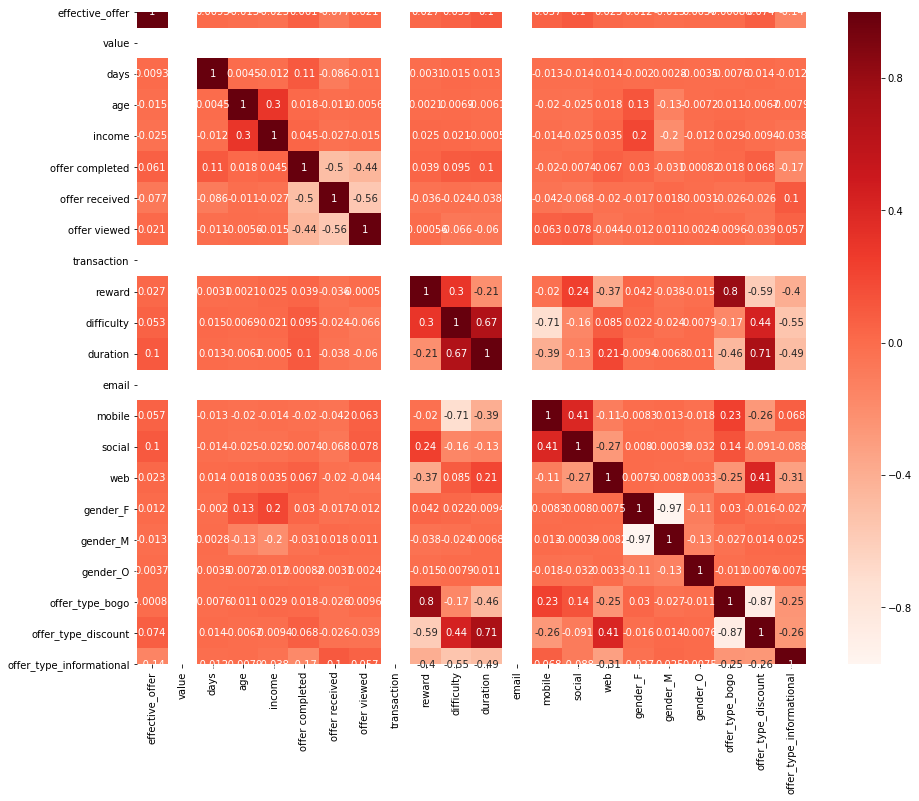

In [165]:
plt.figure(figsize=(15,12))
cor = data_for_models.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [166]:
cor_target = abs(cor['effective_offer'])

cor_target.sort_values(ascending = False)

effective_offer             1.000000
offer_type_informational    0.144208
duration                    0.103864
social                      0.102596
offer received              0.077337
offer_type_discount         0.074124
offer completed             0.061359
mobile                      0.056762
difficulty                  0.053020
reward                      0.027351
income                      0.024844
web                         0.022724
offer viewed                0.021356
age                         0.015111
gender_M                    0.012824
gender_F                    0.011986
days                        0.009254
gender_O                    0.003659
offer_type_bogo             0.000860
value                            NaN
transaction                      NaN
email                            NaN
Name: effective_offer, dtype: float64

'value', 'transaction', 'email' columns do not have relationship with 'effective offer', there are also some columns have not even 0.01 correlation coefficent with effective offer, we will like to drop them as well.

In [167]:
data_for_models = data_for_models.drop(columns = ['value', 'transaction', 'email','gender_O', 'days'], axis = 1)
target = data_for_models['effective_offer']
features = data_for_models.drop('effective_offer', axis =1)
X_train, X_test, y_train, y_test=data_split(features,target)

### Grid Search

In [168]:
#define Grid Search function for decision tree model
def decision_tree_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,20,30],
                'min_samples_split': [2, 5, 10, 15, 20],
                'min_samples_leaf': [2, 5, 10,15, 20]
                }
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [170]:
decision_tree_param_selection(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2}

In [171]:
#define Grid Search function for random forest tree model
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_dist = {'n_estimators': [50, 100, 200],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [5, 7, 10, 15, None],
                  'min_samples_split': [2, 3, 5, 7],
                  'min_samples_leaf': [2, 5, 10,15, 20]
                 }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [172]:
decision_tree_param_selection(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2}

In [173]:
Model_DT = DecisionTreeClassifier(criterion= 'entropy', random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 15,min_samples_leaf=3)

train_predict(Model_DT, X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 443860 samples.
MSE_train: 0.2651
MSE_test: 0.2682
AUC: 0.5418
Training accuracy:0.7349
Test accuracy:0.7318
              precision    recall  f1-score   support

           0     0.6224    0.1095    0.1863     31105
           1     0.7374    0.9741    0.8394     79860

    accuracy                         0.7318    110965
   macro avg     0.6799    0.5418    0.5128    110965
weighted avg     0.7052    0.7318    0.6563    110965



{'train_time': 0.9519143104553223,
 'pred_time': 0.3168768882751465,
 'training_score': 0.7349006443473167,
 'testing_score': 0.7317622673816068}

In [174]:
Model_RF = RandomForestClassifier(random_state=2,max_depth= 7, max_features= 'auto',
                                min_samples_split= 15,n_estimators=50,min_samples_leaf=2)

train_predict(Model_RF, X_train, y_train, X_test, y_test)

RandomForestClassifier trained on 443860 samples.
MSE_train: 0.2676
MSE_test: 0.2692
AUC: 0.5349
Training accuracy:0.7324
Test accuracy:0.7308
              precision    recall  f1-score   support

           0     0.6433    0.0889    0.1562     31105
           1     0.7343    0.9808    0.8398     79860

    accuracy                         0.7308    110965
   macro avg     0.6888    0.5349    0.4980    110965
weighted avg     0.7088    0.7308    0.6482    110965



{'train_time': 36.04745626449585,
 'pred_time': 6.793675422668457,
 'training_score': 0.7324201324742036,
 'testing_score': 0.7307889875185869}

As we can see, finally the model works better is the decision tree model but without change the parameters.

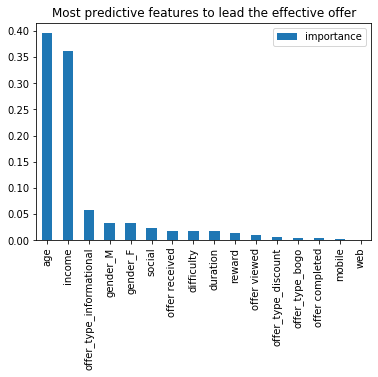

In [175]:
model_final = DecisionTreeClassifier().fit(X_train,y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model_final.feature_importances_

# Plot
feat_imp = pd.DataFrame(model_final.feature_importances_, index=features.columns, columns=['importance']).sort_values('importance',ascending=False)
feat_imp.plot.bar()
plt.title('Most predictive features to lead the effective offer')
plt.show()

The most predictive that the feature can be effient is 'age', 'income', and 'difficuty' of the offer.

# Conclusion

### What do we know from this analysis?

- Who are our customers? What do we learn from them?

I have showed the demographic characteristics for all the customers. Mainly concentrated in 55 - 70 years old, male customers are more than female customers. In general the customers own a middle nivel income, from 50k -70k dollar annually. The the female customers tend to have higher income than male customers.

The customers are divided into 3 groups, promotion affected customers, promotions not affected customers and loyal customers.I provided an extra demographic analysis for each of these groups.

Within the promotion affected customers, the customers are again divided into different offers. Bogo users, discount users and informational promotion users. There is a deeper analysis of demographic characteristics of each promotion user group.

We can also know which group have contributed more in the revenue, and which group have lower CPA.

We also learnt which promotion offer has the most users, which promotion offer gain highest revenue.

- What we can predict based on the customers?

I used different supervised learning models to test and train the data, finally we can see the most predictive features of our customers. 

### What insights we can have from this analysis?

- To push offer type can be based on the customer's average transaction amount. Push lower duration offer to customer with high average amount, which can stimulate their consumption frequency
- For customer with high average transaction amount, the offer's duration should avoid overlap to prevent the customer from completing plural offers with a single order
- When 2 types of promotions have been offered to one customer, they tend to spend more money and have higher probability to convert than customers received 1 type of promotion o 3 types.
- Discount promotion is wider used than other promotion types, it works best as well.